## Script compilation for Processing and Validating Airborne Coastal Observatory (ACO) Snow Surveys
#### Compiled April 2022 for GEOG650
#### Ali Bishop

During the course GEOG650, I have been able to develop and improve an automated python workflow for processing ACO data.  For each arm of the flow chart shown below, I have broken down into sections. A summary table is provided to identify the specific code developed within the coursework of GEOG650, aswell as outstanding work to be done.
\
\
\
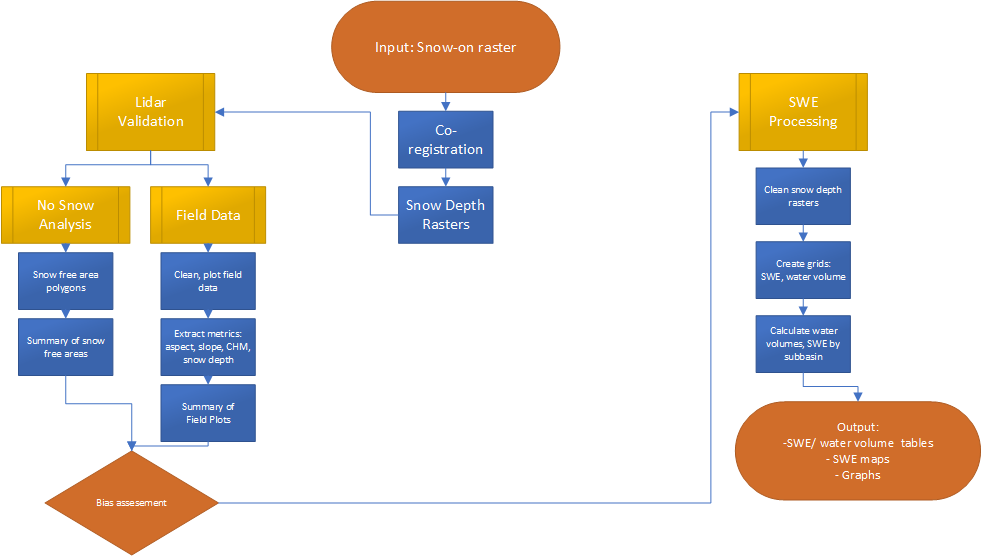

### Preliminary steps
Initial steps for the raster datasets is the snow-on datasets are co-registered to the bare earth, and an inital snowdepth grid is created. 
\
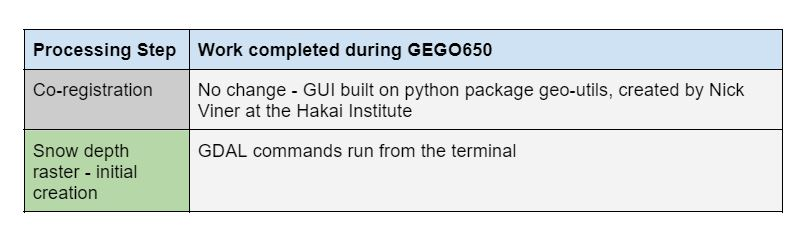









### Create Snow Depth Rasters
Script to run terminal commands to create inititial snow depth grids. The process checks whether the rasters are the same size then will proceed to either A) warp the snow depth grid and subtract the bare earth or B) proceed to subtract the bare earth from snow depth. 
#### Troubleshooting
If issues with subprocess command, this can be run directly from the terminal. The "shell = True" solved my problems as I need to activate my anaconda environment to succesfully run GDAL commands. 

In [ ]:
from osgeo import gdal
import numpy
import os
import rasterio as rio
import subprocess
import sys
from subprocess import Popen, PIPE, CalledProcessError

In [ ]:
#function to subtract the bare earth from the snow on raster to create snow depth grid
def gdal_calc(bareearth_raster, snowon_raster, gdalcalc,snowdepth_name):
    snowdepth_directory = os.path.join("outputs", snowdepth_name)
    print(snowdepth_directory)
     #if this file already exists, gdal_calc will not run 
    if os.path.exists(snowdepth_directory): 
        os.remove(snowdepth_directory)
    cmd_calc = 'python {} -A {} -B {} --outfile={} --calc="A-B"'.format(gdalcalc, snowon_raster, bareearth_raster,snowdepth_directory)
    #this will print the gdal calc processing
    with Popen(cmd_calc, stdout=PIPE, bufsize=1, universal_newlines=True) as p:
        for line in p.stdout:
            print(line, end='') # process line here
    subprocess.run(cmd_calc, shell=True) #should exit with code 0 if succesful 

In [ ]:
#function to first warp the "snowon_raster" to the bare earth if different extents
def gdal_warp(bareearth_raster, snowon_raster, be_read):
    #create the file name by adding warp to the snowon raster file name
    print("creating bounding box..")
    min_x=be_read.bounds[0]
    max_x=be_read.bounds[2]
    min_y=be_read.bounds[1]
    max_y=be_read.bounds[3]
    warp_name= str(snowon_raster)[:-4] + "_warp.tif"
    print(warp_name)
    #if this file already exists, gdawarp will not run 
    if os.path.exists(warp_name): 
        os.remove(warp_name)
    #creating command statement   
    cmd_warp = 'gdalwarp -te {} {} {} {} {} {}'.format(min_x, min_y, max_x, max_y, snowon_raster, warp_name)
    #enabling subprocess to print out live processing
    with Popen(cmd_warp, stdout=PIPE, bufsize=1, universal_newlines=True) as p:
        for line in p.stdout: 
            print(line, end='')
    #call the gdal_warp command
    subprocess.run(cmd_warp, shell=True)
    #return the output file
    return warp_name

In [ ]:
#file directrories, update as needed
bareearth_raster = r"inputs\EGM_BE_wgs84_1m.tif"
snowon_raster =  r"inputs\EGM_P01_STM_coreg.tif"
gdalcalc =  r"inputs\gdal_calc.py"

#based on snow_on raster name, may need to update if your naming convention differs
snowdepth_name = str(snowon_raster)[7:-14] + "_SD.tif"
print(snowdepth_name)

#read in the rasters
be_read = rio.open(bareearth_raster)
snowon_read = rio.open(snowon_raster)

#Check if the rasters are different sizes
if be_read.shape != snowon_read.shape:
    #Warp the snowon raster then reassign the variable
    snowon_raster = gdal_warp(bareearth_raster, snowon_raster, be_read)

#subtract the bare earth from the snow on raster and save in outputs folder
gdal_calc(bareearth_raster, snowon_raster, gdalcalc,snowdepth_name)

### Lidar validation
The Lidar Validation process is used to assess for bias within the data set. 

#### Field data processing
This script below will:
A) Turn a csv file into a georeferenced shapefile
B) Extract information from rasters to points
C) Summarize stats
D) plot points

In [1]:
import fiona
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio as rio
import os
import numpy as np
%matplotlib inline
import seaborn as sns

In [2]:
#define the watershed, phase, and year for plot titles
wshed = "Englishman"
phase = "1"
year = "2021"
title = "{} {} ACO Snow Survey, Phase {}".format(wshed, year, phase)

In [3]:
#read in csv
field_data = pd.read_csv("inputs/EGM_P01_21_fielddata.csv")
display(field_data.head())

,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,core,plug,mass,notes,elevation,longitude,latitude,easting,northing
0,1,3/9/2021 16:36,Englishman,S3F,Cardinal 10 m,Centre,NaN,NaN,240,NaN,0,NaN,NaN,1376.939941,-124.567667,49.203733,385807.369,5451287.001
1,1,3/10/2021 10:39,Englishman,S1A,Cardinal 10 m,Centre,NaN,no,365,345.0,0,1380.0,NaN,1552.520020,-124.571406,49.209643,385548.621,5451949.644
2,1,3/10/2021 12:50,Englishman,E1A,Cardinal 10 m,Centre,NaN,NaN,415,NaN,0,NaN,NaN,1549.069946,-124.572578,49.210793,385465.967,5452079.282
3,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,NaN,320,NaN,0,NaN,NaN,1332.550049,-124.557102,49.199162,386566.412,5450763.019
4,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,no,308,290.0,0,1320.0,NaN,1332.550049,-124.557102,49.199162,386566.412,5450763.019


In [4]:
#extract the crs from the lidar dataset
with rio.open("outputs/EGM_P01_SD.tif") as lidar_sd:
    CRS = lidar_sd.meta["crs"]
#convert the pandas df to gdf
pts = gpd.GeoDataFrame(field_data, geometry=gpd.points_from_xy(field_data.easting, field_data.northing), crs=CRS)

In [5]:
#extract eastings and northings from geodata frame
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pts.index = range(len(pts))
coords = [(x,y) for x,y in zip(pts.easting, pts.northing)]

#load in raster layers and extract the data
def read_extract_raster(pts,infile, variable):
    col_name = str(variable)
    variable = rio.open(infile, masked=True)
    #identify no data value
    nodataval = variable.nodatavals
    #extract the no data value from tuple
    nodataval=nodataval[0]
    #loop through the data points and sample the raster value
    pts[col_name]=[x[0] for x in variable.sample(coords)]
    #assign 0 to no data values of CHM
    if "canopy" in col_name:
        pts[col_name] = pts[col_name].map(lambda x: 0 if x == nodataval  else x)
    else:
    #assign NaN to the no data values for else
        pts[col_name] = pts[col_name].map(lambda x: np.nan if x == nodataval  else x)
    # return the dataframe
    return pts

#run function to extract raster data 
pts = read_extract_raster(pts,"inputs/Englishman_1m_Canopy_Height_WGS84_z10.tif","canopy_height")
pts = read_extract_raster(pts, "inputs/Englishman_1m_Canopy_Density_WGS84_z10.tif", "canopy_density")
pts = read_extract_raster(pts, "inputs/Englishman_1m_Canopy_Cover_WGS84_z10.tif", "canopy_cover")
pts = read_extract_raster(pts, "inputs/EGM_aspect.tif", "aspect")
pts = read_extract_raster(pts, "inputs/EGM_BE_wgs84_1m.tif", "elevation")
pts = read_extract_raster(pts,"outputs/EGM_P01_SD.tif", "SD_lidar")
pts = read_extract_raster(pts,"inputs/EGM_slope.tif", "slope")

#format fields, create differnece in snow depth column
pts["SD_lidar"]  = round(pts["SD_lidar"]*100)
pts["field - lidar"] = pts["depth"]-pts["SD_lidar"]



def aspect(df, old_col, new_col):
    conditions_asp = [
        df[old_col] == -1,
        df[old_col] <= 22.5,
        df[old_col] <= 67.5,
        df[old_col] <= 112.5,
        df[old_col] <= 157.5,
        df[old_col] <= 202.5,
        df[old_col] <= 247.5,
        df[old_col] <= 292.5,
        df[old_col] <= 337.5,
        df[old_col] <= 360]

    values_asp = ["Flat", "North", "Northeast", "East", "Southeast", "South", "Southwest", "West", "Northwest", "North"]
    df[new_col] = np.select(conditions_asp, values_asp)

aspect(pts, "aspect", "aspect_cardinal")

def canopy_cover(df, old_col,new_col):
    conditions = [
        df[old_col] == 0,
        df[old_col] <=50, 
        df[old_col] <=100
    ]
    values = ["open", "sparse trees", "under canopy"]
    df[new_col]=np.select(conditions, values)
canopy_cover(pts, "canopy_cover", "cover_type")
display(pts.head())
#export data to csv
outfile = "{}_P0{}_lidar_data.csv".format(wshed,phase)
pts.to_csv(os.path.join("outputs", "field_data", outfile),index=False)

,aco_flight_number,plot_datetime,study_area,plot_id,plot_type,cardinal,distance,multi_core,depth,core,...,geometry,canopy_height,canopy_density,canopy_cover,aspect,SD_lidar,slope,field - lidar,aspect_cardinal,cover_type
0,1,3/9/2021 16:36,Englishman,S3F,Cardinal 10 m,Centre,NaN,NaN,240,NaN,...,POINT (385807.369 5451287.001),5,75.000,75.000,236.842,245.000,18.818,-5.000,Southwest,under canopy
1,1,3/10/2021 10:39,Englishman,S1A,Cardinal 10 m,Centre,NaN,no,365,345.000,...,POINT (385548.621 5451949.644),2,50.000,60.000,148.050,343.000,12.310,22.000,Southeast,under canopy
2,1,3/10/2021 12:50,Englishman,E1A,Cardinal 10 m,Centre,NaN,NaN,415,NaN,...,POINT (385465.967 5452079.282),0,0.000,0.000,307.078,409.000,12.186,6.000,Northwest,open
3,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,NaN,320,NaN,...,POINT (386566.412 5450763.019),0,0.000,0.000,314.521,302.000,8.842,18.000,Northwest,open
4,1,3/11/2021 13:51,Englishman,N2F,Cardinal 10 m,Centre,NaN,no,308,290.000,...,POINT (386566.412 5450763.019),0,0.000,0.000,314.521,302.000,8.842,6.000,Northwest,open


In [6]:
#convert gdf to df
df = pd.DataFrame(pts)

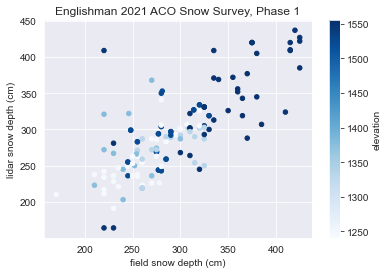

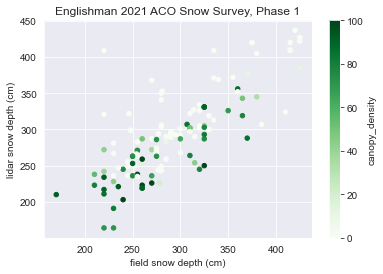

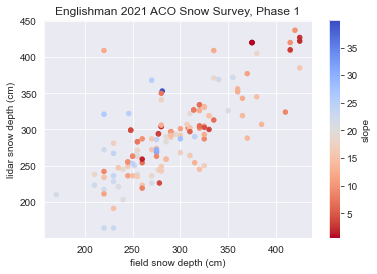

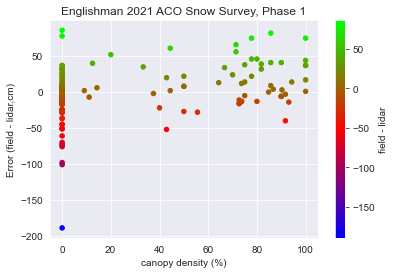

In [7]:
#generate a quick scatter plot of overall field data to summarize by raster elements
def plot_variable(df, x, y, title, color, cmap, xlabel, ylabel, outfolder):
    sns.set_style("darkgrid")
    fig, ax = plt.subplots()
    #fig = plt.figure(facecolor=(1, 1, 1))
    df.plot(kind="scatter", x=x,y=y,c=color, cmap=cmap, ax=ax)
    ax.set(xlabel=xlabel, ylabel=ylabel,title=title)
    output = "{}_P0{}_{}_{}_{}.jpg".format(wshed,phase,x,y,color)
    graph_directory = os.path.join(outfolder,output)
    fig = ax.get_figure()
    fig.savefig(graph_directory, dpi=300)
    
#geneates individual plots, could combine into one figure here too. 
#Can mix and match variables within dataframe to generate other graphs
plot_variable(df, "depth", "SD_lidar", title, "elevation", "Blues","field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "depth", "SD_lidar", title, "canopy_density", "Greens","field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "depth", "SD_lidar", title, "slope", 'coolwarm_r',"field snow depth (cm)","lidar snow depth (cm)",
"outputs/field_data")
plot_variable(df, "canopy_density", "field - lidar", title, "field - lidar", "brg", "canopy density (%)","Error (field - lidar,cm)",
"outputs/field_data")

In [9]:
#generate a summary table of results
def summary_stats(df,out_directory, wshed, phase):
    sum = df.groupby(
        "plot_id").agg({
        "depth": ["mean", "std", "count"],
        "SD_lidar": ["mean", "std"],
        "field - lidar" : "mean",
        "slope": "mean",
        "canopy_cover": "mean",
        "canopy_height": "mean",
        "elevation" : "mean",
        "aspect": ["min", "max"]
    
        }).round(2)
    display(sum)
    output = "{}_P0{}_plot_summaries.csv".format(wshed,phase)
    sum.to_csv(os.path.join(out_directory, output))

summary_stats(df, "outputs/field_data", wshed, phase)

depth              SD_lidar        field - lidar  slope  \
           mean    std count     mean    std          mean   mean   
plot_id                                                             
E1A     354.550 63.940    22  366.320 77.250       -11.770 11.060   
E3F     268.170 33.960    18  272.560 40.460        -4.390 13.500   
N1A     281.600 24.810    30  289.500 33.970        -7.900 12.080   
N2F     291.830 27.000    18  278.170 22.060        13.670 13.510   
S1A     338.750 41.230    20  314.950 36.700        23.800 14.530   
S3F     254.190 27.060    16  271.440 43.160       -17.250 22.390   
W3F     244.590 27.200    17  237.940 17.750         6.650 18.020   

        canopy_cover canopy_height elevation  aspect          
                mean          mean      mean     min     max  
plot_id                                                       
E1A            7.570         0.180  1549.790  86.150 356.400  
E3F           44.510         5.220  1242.140  64.140 173.120  
N1A            0.000         0.000  1522.940   3.490 347.450  
N2F           44.930         5.610  1332.920  15.670 358.080  
S1A           63.100         3.450  1552.620 129.690 199.540  
S3F           39.580         3.440  1376.960 231.810 277.230  
W3F           61.410         8.350  1245.010  26.180 335.720

E1A
W3F
E3F
S3F
N2F
S1A
N1A


<Figure size 432x288 with 0 Axes>

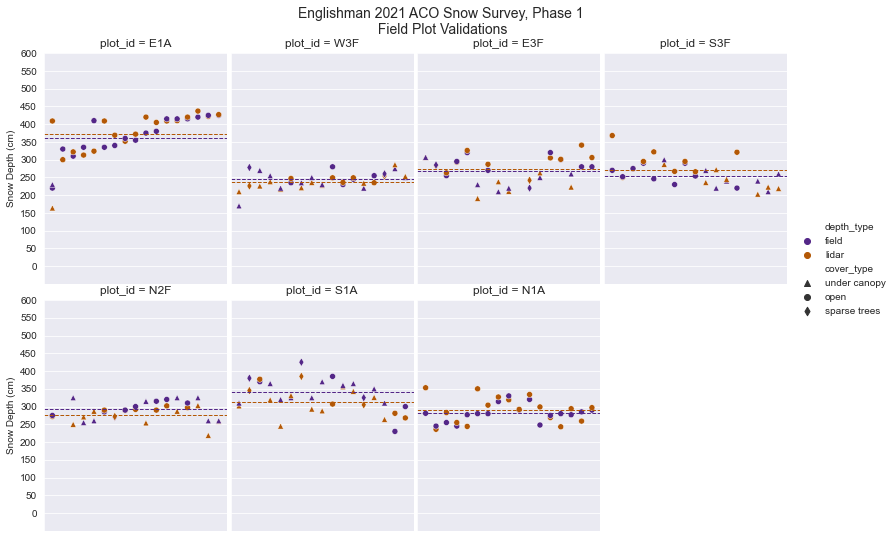

In [11]:
#graph the individual plots we want the y axis to be the same between phases
#graph code isn't pretty but she works!!

def field_plots_compare_graph(df,ymin,ymax,top_margin,title, outfolder):
    df = df.rename(columns={"depth" : "field", "SD_lidar" : "lidar"})
    #melt the dataframe to longform
    df=df.melt(id_vars=["plot_id", "cardinal", "distance", "cover_type"], value_vars=["field", "lidar"], var_name="depth_type", value_name="snow_depth")
    #create unique point value
    df["id"]= df["cardinal"]+df["distance"].astype(str)
    subset = df.columns.difference(['snow_depth'])
    #drop duplicate entries from subset less depth; some values have two depths that differ slightly from denisties vs probes
    df = df.sort_values("snow_depth", ascending=True).drop_duplicates(subset=subset, keep="last")
    #set up graph
    sns.set_style("darkgrid")
    sns.despine(left=True)
    #set font sizes
    SMALL_SIZE = 10
    MEDIUM_SIZE = 12
    BIGGER_SIZE = 14
    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    #Create facet grid
    g = sns.FacetGrid(df, col="plot_id", col_wrap=4, height = 4, aspect = .7)
    #g.set(ylim=(ymin, ymax), yticks=np.arange(500,50))
    g.set(ylim=(-50, 500), yticks=[0,50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
    
    #create plots and iterate over
    for col, col_name in enumerate(g.col_names):
        #print(col_name)
        ax = g.axes[col]
        filter = df[df["plot_id"] == col_name]
        groupby = filter.groupby(["depth_type"],as_index=False).snow_depth.mean()
        field_avg = groupby[groupby["depth_type"] == "field"]
        lidar_avg = groupby[groupby["depth_type"] == "lidar"]
        field_avg_pos = field_avg["snow_depth"].values[0]
        lidar_avg_pos = lidar_avg["snow_depth"].values[0]
        #print(field_avg_pos)
        #print(lidar_avg_pos)
        ax.axhline(field_avg_pos, color="#542788", ls="--", lw=1)
        ax.xaxis.grid(False)
        ax.axhline(lidar_avg_pos, color="#b35806", ls="--", lw=1)
    
    hue_order = ["field", "lidar"]
    # Field is purple, Lidar is orange
    palette = {"field" : "#542788", "lidar":"#b35806"}
    markers = {"open":"o", "sparse trees" : "d", "under canopy" : "^"}
    g = g.map_dataframe(sns.scatterplot, "id", "snow_depth", hue="depth_type", style="cover_type", markers = markers, hue_order = hue_order, palette = palette)
    g = g.set(xticklabels=[], xlabel=None)
    g.set_ylabels(size = 10, label = "Snow Depth (cm)")
    g = g.add_legend()

    #add title and adjust margins, can customize top margin value in function
    plt.suptitle(title + "\n Field Plot Validations")
    plt.subplots_adjust(hspace=0.07, wspace=0.02, top=top_margin)
    
    #set export file name and directroy
    output = "{}_P0{}_validation_plots.jpg".format(wshed,phase)
    graph_directory = os.path.join(outfolder, output)
    plt.savefig(graph_directory, dpi=300)
    
    plt.show()
    
field_plots_compare_graph(df, -50, 500,.9,title, "outputs/field_data")